##Домашнее задание №1

Педченко Андрей
MADE-ML-32

###Часть первая, с блекджеком и стратегиями



1.   Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2.   Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
2.   Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.




In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import pyplot
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

In [2]:
env = gym.make('Blackjack-v0')
env.natural = True

Рассмотрим очень простую стратегию

In [ ]:
def simple_policy(env):
  rewards = []
  for _ in range(500000):
    state = env.reset()
    final = False
    while not final:
      state, reward, final, _ = env.step(0 if state[0] > 18 else 1)    
    rewards.append(reward)

  return np.mean(rewards)

In [ ]:
simple_reward = simple_policy(env)
print("Средняя награда при простой стратегии около", simple_reward)

Средняя награда при простой стратегии около -0.180026


Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии

In [ ]:
# Брал фрагменты кода из статьи https://habr.com/ru/company/otus/blog/477042/

In [ ]:
def sample_policy(state):
  score, dealer_score, usable_ace = state
  return 0 if score >= 18 else 1

def generate_episode(policy, env):
    
  states, actions, rewards = [], [], []
  state = env.reset()
  
  while True:
    states.append(state)
    action = sample_policy(state)
    actions.append(action)
    state, reward, final, _ = env.step(action)
    rewards.append(reward)

    if final:
      break
              
  return states, actions, rewards

In [ ]:
def first_visit_mc_prediction(policy, env, n_episodes):
  
  value_table = defaultdict(float)
  N = defaultdict(int)

  for _ in range(n_episodes):

    states, _, rewards = generate_episode(policy, env)
    returns = 0
    
    for t in range(len(states) - 1, -1, -1):
      R = rewards[t]
      S = states[t]
      returns += R
      
      if S not in states[:t]:
        N[S] += 1
        value_table[S] += (returns - value_table[S]) / N[S]
  
  return value_table

In [ ]:
value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)

print('Различные состояния и их награды')
for i in range(10):
  print(value.popitem())

Различные состояния и их награды
((12, 1, True), -0.22274881516587683)
((12, 2, True), 0.11737089201877937)
((4, 2, False), -0.20746887966804978)
((15, 2, True), -0.09176029962546815)
((4, 7, False), -0.07177033492822964)
((20, 7, True), 0.75886524822695)
((15, 3, True), -0.10820895522388062)
((19, 3, True), 0.40053404539385834)
((7, 3, False), -0.3278327832783278)
((15, 7, True), 0.072072072072072)


In [ ]:
rewards = []
for k, v in value.items():
  rewards.append(v)
print("По Монте-Карло выигрыш от этой стратегии около", np.mean(rewards))

По Монте-Карло выигрыш от этой стратегии около -0.005321960235059259


Реализуйте метод обучения с подкреплением без модели

In [3]:
class QL:
  def __init__(self, alpha=0.005, epsilon=0.55, gamma=0.75):
    self.Q = {}
    self.actions = [0, 1]
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
      
  def get_rewards_from_Q(self, state):
    if state not in self.Q:
      self.Q[state] = np.zeros(2)
    return self.Q[state]
  
  def get_reward_for_action_from_Q(self, state, action):
    return self.get_rewards_from_Q(state)[action]

  def learn_episode(self, steps, reward):
    for state, action in steps[::-1]:
      reward = self.get_reward_for_action_from_Q(state, action) + self.alpha * (reward + self.gamma * np.max(self.Q[state]) - self.get_reward_for_action_from_Q(state, action))
      self.Q[state][action] = reward

In [4]:
def q_learning_episode(env, ql):
  state = env.reset()
  final = False
  steps = []
  while not final:
    if np.random.rand() <= ql.epsilon:
      action = random.choice([0, 1])
    else:
      action = np.argmax(ql.get_rewards_from_Q(state))
    steps.append((state, action))
    state, reward, final, _ = env.step(action)    
  return steps, reward

In [ ]:
search_params = {}

for e in np.linspace(0.05, 1, 10):
  for a in np.linspace(0.000001, 0.001, 10):
    for g in np.linspace(0.05, 1, 10):
      ql = QL(alpha=a, epsilon=e, gamma=g)
      reward_for_plot = []
      cum_reward = 0
      for n in range(3000):
        steps, reward = q_learning_episode(env, ql)
        ql.learn_episode(steps, reward)
        cum_reward += reward
        reward_for_plot.append(cum_reward/(n + 1))
      search_params[(a, e, g)] = np.mean(reward_for_plot[100:])

In [ ]:
import operator
a, e, g = max(search_params.items(), key=operator.itemgetter(1))[0]
print('Наиболее оптимальные параметры')
print(a, e, g)

Наиболее оптимальные параметры
0.001 0.05 1.0


In [ ]:
ql = QL(alpha=a, epsilon=e, gamma=g)
reward_for_plot = []
cum_reward = 0
for n in range(500000):
  steps, reward = q_learning_episode(env, ql)
  ql.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

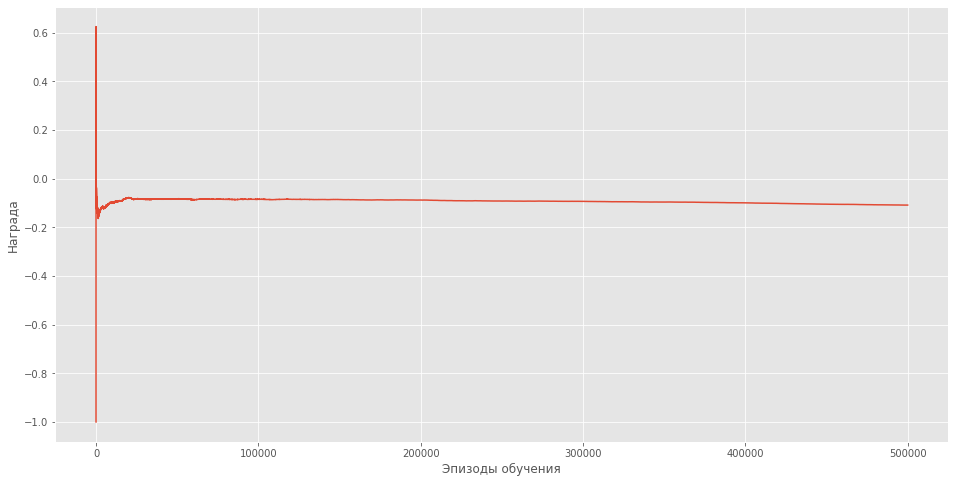

Средняя награда при Q-обучении около -0.09327838150370146


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.show()
print("Средняя награда при Q-обучении около", np.mean(reward_for_plot))

##Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4.   Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5.   Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.






In [ ]:
# Взято из оригинала https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py
# Добавлено 3-е действие

from gym import spaces
from gym.utils import seeding

def cmp(a, b):
  return float(a > b) - float(a < b)


deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
  return int(np_random.choice(deck))


def draw_hand(np_random):
  return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
  return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
  if usable_ace(hand):
    return sum(hand) + 10
  return sum(hand)


def is_bust(hand):  # Is this hand a bust?
  return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
  return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
  return sorted(hand) == [1, 10]


class DoubleBlackjackEnv(gym.Env):

  def __init__(self, natural=False):
    self.action_space = spaces.Discrete(3)
    self.observation_space = spaces.Tuple((
      spaces.Discrete(32),
      spaces.Discrete(11),
      spaces.Discrete(2)))
    self.seed()
    self.natural = natural
    self.reset()

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def step(self, action):
    assert self.action_space.contains(action)
    if action == 1:  # hit: add a card to players hand and return
      self.player.append(draw_card(self.np_random))
      if is_bust(self.player):
        done = True
        reward = -1.
      else:
        done = False
        reward = 0.

    elif action == 0:  # stick: play out the dealers hand, and score
      done = True
      while sum_hand(self.dealer) < 17:
        self.dealer.append(draw_card(self.np_random))
      reward = cmp(score(self.player), score(self.dealer))
      if self.natural and is_natural(self.player) and reward == 1.:
        reward = 1.5

    elif action == 2:
      self.player.append(draw_card(self.np_random))
      done = True
      while sum_hand(self.dealer) < 17:
        self.dealer.append(draw_card(self.np_random))
      reward = cmp(score(self.player), score(self.dealer))
      if self.natural and is_natural(self.player) and reward == 1.:
        reward = 1.5
      reward *= 2

    return self._get_obs(), reward, done, {}

  def _get_obs(self):
    return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

  def reset(self):
    self.dealer = draw_hand(self.np_random)
    self.player = draw_hand(self.np_random)
    return self._get_obs()

In [13]:
# Добавлено третье действие

class QL:
  def __init__(self, alpha=0.005, epsilon=0.55, gamma=0.75):
    self.Q = {}
    self.actions = [0, 1, 2]
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
      
  def get_rewards_from_Q(self, state):
    if state not in self.Q:
      self.Q[state] = np.zeros(3)
    return self.Q[state]
  
  def get_reward_for_action_from_Q(self, state, action):
    return self.get_rewards_from_Q(state)[action]

  def learn_episode(self, steps, reward):
    for state, action in steps[::-1]:
      reward = self.get_reward_for_action_from_Q(state, action) + self.alpha * (reward + self.gamma * np.max(self.Q[state]) - self.get_reward_for_action_from_Q(state, action))
      self.Q[state][action] = reward

In [ ]:
# Добавлено третье действие

def q_learning_episode(env, ql):
  state = env.reset()
  final = False
  steps = []
  while not final:
    if np.random.rand() <= ql.epsilon:
      action = random.choice([0, 1, 2])
    else:
      action = np.argmax(ql.get_rewards_from_Q(state))
    steps.append((state, action))
    state, reward, final, _ = env.step(action)    
  return steps, reward

In [ ]:
env = DoubleBlackjackEnv()
env.natural = True

In [ ]:
search_params = {}

for e in np.linspace(0.05, 1, 10):
  for a in np.linspace(0.000001, 0.001, 10):
    for g in np.linspace(0.05, 1, 10):
      ql = QL(alpha=a, epsilon=e, gamma=g)
      reward_for_plot = []
      cum_reward = 0
      for n in range(3000):
        steps, reward = q_learning_episode(env, ql)
        ql.learn_episode(steps, reward)
        cum_reward += reward
        reward_for_plot.append(cum_reward/(n + 1))
      search_params[(a, e, g)] = np.mean(reward_for_plot[100:])

a, e, g = max(search_params.items(), key=operator.itemgetter(1))[0]
print('Наиболее оптимальные параметры')
print(a, e, g)

Наиболее оптимальные параметры
0.0004450000000000001 0.05 0.6833333333333333


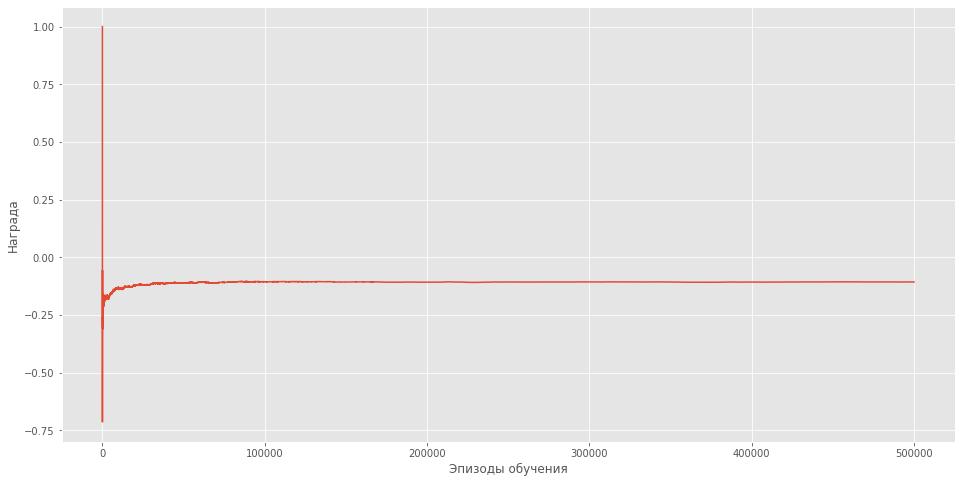

Средняя награда при Q-обучении с удвоением ставки около -0.10945998851078943


In [ ]:
ql = QL(alpha=a, epsilon=e, gamma=g)
reward_for_plot = []
cum_reward = 0
for n in range(500000):
  steps, reward = q_learning_episode(env, ql)
  ql.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.show()
print("Средняя награда при Q-обучении с удвоением ставки около", np.mean(reward_for_plot))

Практически без изменений

##Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Думаю, у вас уже возникла в голове эта картинка:

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.


6.   Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
7.   Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.




In [110]:
# Взято из оригинала https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py
# Добавлен подсчет

from gym import spaces
from gym.utils import seeding

def cmp(a, b):
  return float(a > b) - float(a < b)


# deck  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

# На основе методики подсчета из вики https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

def get_score(x):
  score = 0
  if x in [2, 3, 4, 5, 6]:
    score = 1
  elif x in [1, 10]:
    score = -1
  return score

# def get_score(x):
#   score = 0
#   if x in [2, 7]:
#     score = 0.5
#   elif x in [3, 4, 6]:
#     score = 1
#   elif x in [5]:
#     score = 1.5
#   elif x in [9]:
#     score = -0.5
#   elif x in [1, 10]:
#     score = -1
#   return score

# def draw_card(np_random):
#   return int(np_random.choice(deck))


# def draw_hand(np_random):
#   return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
  return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
  if usable_ace(hand):
    return sum(hand) + 10
  return sum(hand)


def is_bust(hand):  # Is this hand a bust?
  return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
  return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
  return sorted(hand) == [1, 10]


class CountingDoubleBlackjackEnv(gym.Env):

  def __init__(self, natural=False):
    self.action_space = spaces.Discrete(3)
    self.observation_space = spaces.Tuple((
      spaces.Discrete(32),
      spaces.Discrete(11),
      spaces.Discrete(2),
      spaces.Discrete(20)))
    self.seed()
    self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
    random.shuffle(self.deck)
    self.count = 0
    self.natural = natural
    self.reset()

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

# Кажется нечестным в этом окружении, что карты достаются рандомно из оставшейся колоды,
# поэтому делаю, чтобы при инициализации колода один раз тасовалась, и дальше сдавалась всегда первая карта сверху

  def draw_card(self, np_random):
    card = self.deck[0]
    self.deck.remove(card)
    return card

  def draw_hand(self, np_random):
    return [self.draw_card(np_random), self.draw_card(np_random)]

  def count_card(self, card):
    self.count += get_score(card) 

  def step(self, action):
    assert self.action_space.contains(action)
    if action == 1:  # hit: add a card to players hand and return
      card = self.draw_card(self.np_random)
      self.count_card(card)
      self.player.append(card)
      if is_bust(self.player):
        done = True
        reward = -1.
      else:
        done = False
        reward = 0.

    elif action == 0:  # stick: play out the dealers hand, and score
      done = True
      while sum_hand(self.dealer) < 17:
        self.dealer.append(self.draw_card(self.np_random))
      for card in self.dealer[1:]:
        self.count_card(card)
      reward = cmp(score(self.player), score(self.dealer))
      if self.natural and is_natural(self.player) and reward == 1.:
        reward = 1.5

    else:
      card = self.draw_card(self.np_random)
      self.count_card(card)
      self.player.append(card)
      done = True
      while sum_hand(self.dealer) < 17:
        self.dealer.append(self.draw_card(self.np_random))
      for card in self.dealer[1:]:
        self.count_card(card)
      reward = cmp(score(self.player), score(self.dealer))
      if self.natural and is_natural(self.player) and reward == 1.:
        reward = 1.5
      reward *= 2

    return self._get_obs(), reward, done, {}

  def _get_obs(self):
    return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.count)

  def reset(self):
    if len(self.deck) < 15:
      self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
      random.shuffle(self.deck)
      self.count = 0
    self.dealer = self.draw_hand(self.np_random)
    self.player = self.draw_hand(self.np_random)
    self.count_card(self.dealer[0])
    self.count_card(self.player[0])
    self.count_card(self.player[1])
    return self._get_obs()

In [129]:
# Добавлена проверка счетчика
# Тут я разные условия выставлял, но казино все равно не удается обыграть
# С текущими условиями был достигнут наилучший результат

def q_learning_episode(env, ql):
  state = env.reset()
  final = False
  steps = []
  while not final:
    if env.count > 4:
      action = 2
    elif env.count < -3:
      action = 0
    else:
      action = np.argmax(ql.get_rewards_from_Q(state))
    steps.append((state, action))
    state, reward, final, _ = env.step(action)    
  return steps, reward

# def q_learning_episode(env, ql):
#   state = env.reset()
#   final = False
#   steps = []
#   while not final:
#     if env.count > 3:
#       action = 2
#     else:
#       action = np.argmax(ql.get_rewards_from_Q(state))
#     steps.append((state, action))
#     state, reward, final, _ = env.step(action)    
#   return steps, reward

In [130]:
env = CountingDoubleBlackjackEnv()
env.natural = True

In [96]:
search_params = {}

for e in np.linspace(0.05, 1, 10):
  for a in np.linspace(0.000001, 0.001, 10):
    for g in np.linspace(0.05, 1, 10):
      ql = QL(alpha=a, epsilon=e, gamma=g)
      reward_for_plot = []
      cum_reward = 0
      for n in range(3000):
        steps, reward = q_learning_episode(env, ql)
        ql.learn_episode(steps, reward)
        cum_reward += reward
        reward_for_plot.append(cum_reward/(n + 1))
      search_params[(a, e, g)] = np.mean(reward_for_plot[100:])

a, e, g = max(search_params.items(), key=operator.itemgetter(1))[0]
print('Наиболее оптимальные параметры')
print(a, e, g)

Наиболее оптимальные параметры
0.00022300000000000003 0.5777777777777778 1.0


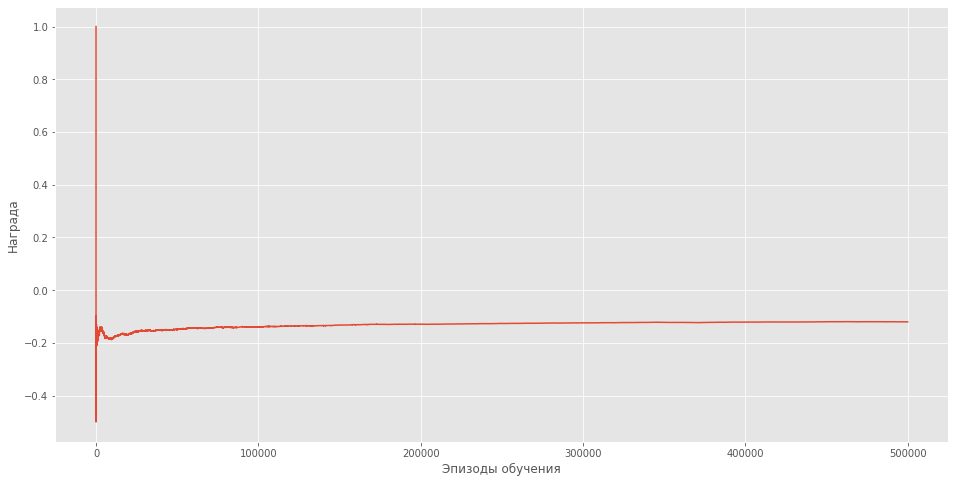

Средняя награда при Q-обучении с удвоением ставки и подсчетом около -0.1307958998560498


In [131]:
ql = QL(alpha=a, epsilon=e, gamma=g)
reward_for_plot = []
cum_reward = 0
for n in range(500000):
  steps, reward = q_learning_episode(env, ql)
  ql.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.show()
print("Средняя награда при Q-обучении с удвоением ставки и подсчетом около", np.mean(reward_for_plot))

Всё равно не удается обыграть казино(

In [135]:
# Интересно, что если просуммировать реворды всех сэмплов по действиям, 
# то выходит, что нулевое действие оказывалось более выгодным, но если всегда выбирать
# действие ноль, то все равно не выиграть.

rews = []
for k,v in ql.Q.items():
  rews.append(v)

rews = np.array(rews)
rews.sum(axis=0)

array([  8.67085079, -10.10386219, -11.85612577])

##Часть четвёртая, опциональная

Ну и напоследок ещё парочка опциональных заданий за дополнительные баллы.


8.   Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. вероятности переходов между состояниями.
9.   Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!

Делаю только 9й пункт со сплитом

In [136]:
def q_learning_episode(env, ql):
  state = env.reset()
  final = False
  steps = []
  while not final:

    if env.player[0] == env.player[0]:
      state2 = state
      env2 = env
      env2.player = env.player
      env2.dealer = env.dealer
      env2.count = env.count
      env2.deck = env.deck
      final1 = False
      final2 = False

      while not (final1 and final2):

        if env.count > 4:
          action = 2
        elif env.count < -3:
          action = 0
        else:
          action = np.argmax(ql.get_rewards_from_Q(state))

        action2 = action
        steps.append((state, action))
        state, reward, final1, _ = env.step(action) 
        state2, reward2, final2, _ = env.step(action2) 
        reward = reward + reward2
      final = True

    else:
      if env.count > 4:
        action = 2
      elif env.count < -3:
        action = 0
      else:
        action = np.argmax(ql.get_rewards_from_Q(state))
      steps.append((state, action))
      state, reward, final, _ = env.step(action) 
   
  return steps, reward

In [82]:
env = CountingDoubleBlackjackEnv()
env.natural = True

search_params = {}

for e in np.linspace(0.05, 1, 10):
  for a in np.linspace(0.0001, 0.05, 10):
    for g in np.linspace(0.05, 1, 10):
      ql = QL(alpha=a, epsilon=e, gamma=g)
      reward_for_plot = []
      cum_reward = 0
      for n in range(3000):
        steps, reward = q_learning_episode(env, ql)
        ql.learn_episode(steps, reward)
        cum_reward += reward
        reward_for_plot.append(cum_reward/(n + 1))
      search_params[(a, e, g)] = np.mean(reward_for_plot[100:])

a, e, g = max(search_params.items(), key=operator.itemgetter(1))[0]
print('Наиболее оптимальные параметры')
print(a, e, g)

Наиболее оптимальные параметры
0.0001 1.0 0.05


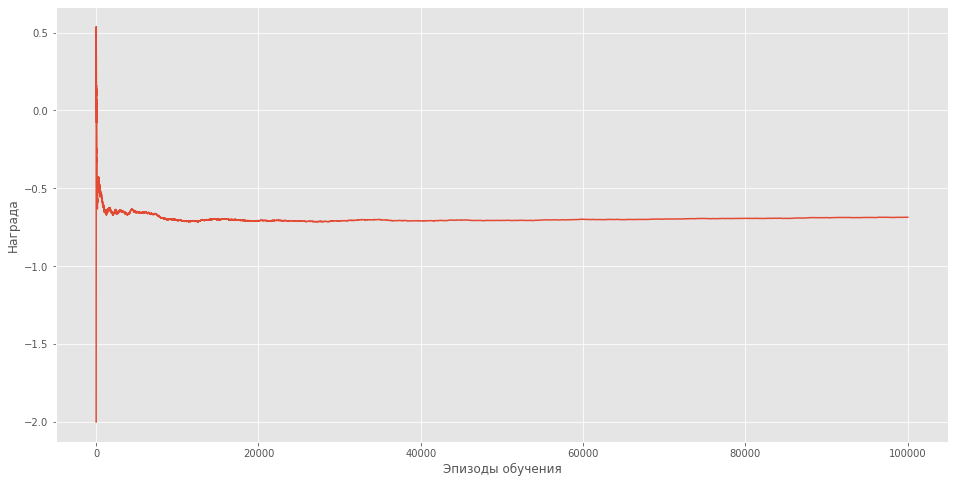

Средняя награда при Q-обучении около -0.695067457810615


In [137]:
ql = QL(alpha=a, epsilon=e, gamma=g)
reward_for_plot = []
cum_reward = 0
for n in range(100000):
  steps, reward = q_learning_episode(env, ql)
  ql.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.show()
print("Средняя награда при Q-обучении около", np.mean(reward_for_plot))

Ну тут явно я что-то не так делаю.